#Anime recommendation - Evaluation

In this notebook, we will go through all the evaluation steps, and we will conduct a full experiment.
Some of the material in this notebook are essential for understanding the data better (e.g., exploratory data analysis).

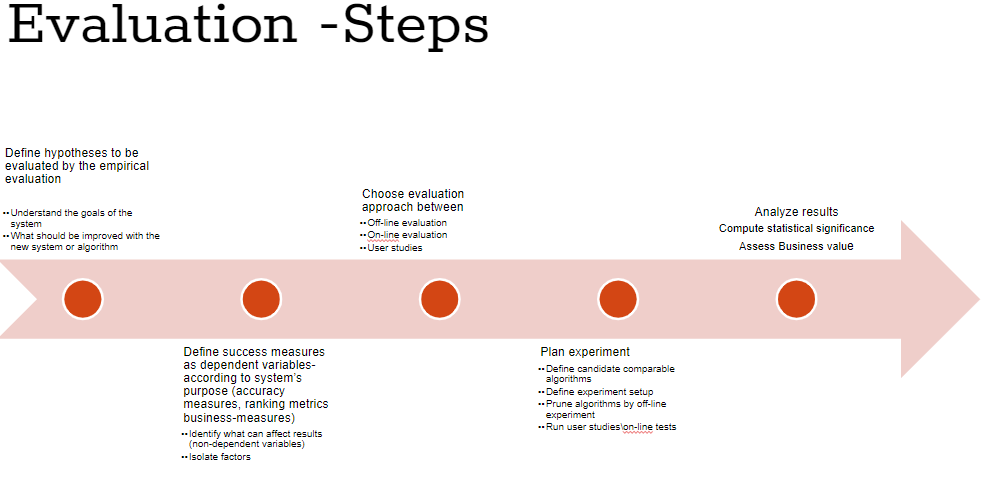

# 1. Hypotheses
Adding an additional feature and utilize it as an additional bias to MF can improve MF accuracy results for rating prediction problem.

# 2. Define Success Measure
The success measure needs to be defined. In this notebook, we will use RMSE.

# 3. Evaluation Approch
We will perform an off-line evaluation. 

The off-line evaluation approach includes the following steps:
1. Pre-evaluation
2. Splitting data
3. Building a model
4. Applying the model
5. Compare the predicted rating on the test set

We will expand this section later on in this notebook.

## 3.1 Pre-evaluation
In this subsection, we will:
1. Decide on an appropriate dataset and load it.
2. Prepare the data (e.g., clean the data, fill in missing values, etc.')




### 3.1.1 Decide on an appropiate dataset

We will download the [Anime recommendation dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database). 

This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating, and this data set is a compilation of those ratings.

We will import the dataset from Kaggle to colab - 
[Instructions](https://www.kaggle.com/general/74235).


*** Todo: talk about research vs this example ****

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amitlivne","key":"514244e5b2b6a209335feb180aab92cf"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d CooperUnion/anime-recommendations-database

In [ ]:
!mkdir anime
#unzip dataset into a dedicated folder ("anime")
!unzip anime-recommendations-database.zip -d anime

Archive:  anime-recommendations-database.zip
  inflating: anime/anime.csv         
  inflating: anime/rating.csv        


In [ ]:
import os
import pandas as pd

os.chdir('/content/anime')
rating_df = pd.read_csv('rating.csv')
anime_df = pd.read_csv('anime.csv')


**Exploratory Data Analysis (EDA)**

This component aims to analyze datasets to summarize their main characteristics, often with visual methods.

For example, display histograms, scatterplots, etc.' to create a better understanding of the dataset.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def overview(df):
    """
    this function will print some basic informaiton regards the dataframe
    """
    print('number of rows {} , number of columns {}'.format(df.shape[0],df.shape[1]))
    print('columns names: {}'.format(df.columns))    
    
    print('missing data')
    c=df.isnull().sum()
    print(c[c>0])

In [ ]:
overview(anime_df)
print('='*70)
overview(rating_df)

number of rows 12294 , number of columns 7
columns names: Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')
missing data
genre      62
type       25
rating    230
dtype: int64
number of rows 7813737 , number of columns 3
columns names: Index(['user_id', 'anime_id', 'rating'], dtype='object')
missing data
Series([], dtype: int64)


EDA

In this section we present some preliminary graphs for better understands the data.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


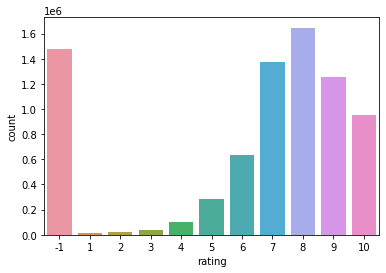

In [ ]:
sns.countplot(rating_df['rating'])

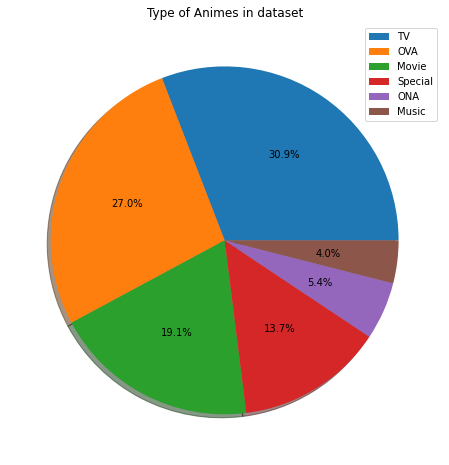

In [ ]:
anime_df['type'].value_counts().plot.pie(autopct='%.1f%%',labels=None,shadow=True,figsize=(8,8))
plt.title('Type of Animes in dataset')
plt.ylabel('')
plt.legend(anime_df['type'].value_counts().index.tolist(),loc='upper right')
plt.show()

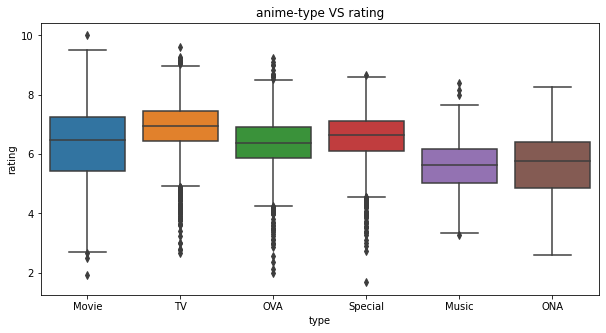

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='type',y='rating',data=anime_df)
plt.title('anime-type VS rating')
plt.show()

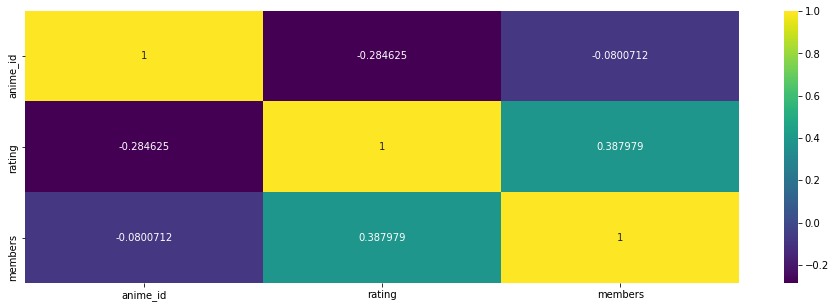

In [ ]:
plt.figure(figsize = (16,5))
sns.heatmap(anime_df.corr(), annot=True, fmt="g", cmap='viridis')
plt.show()

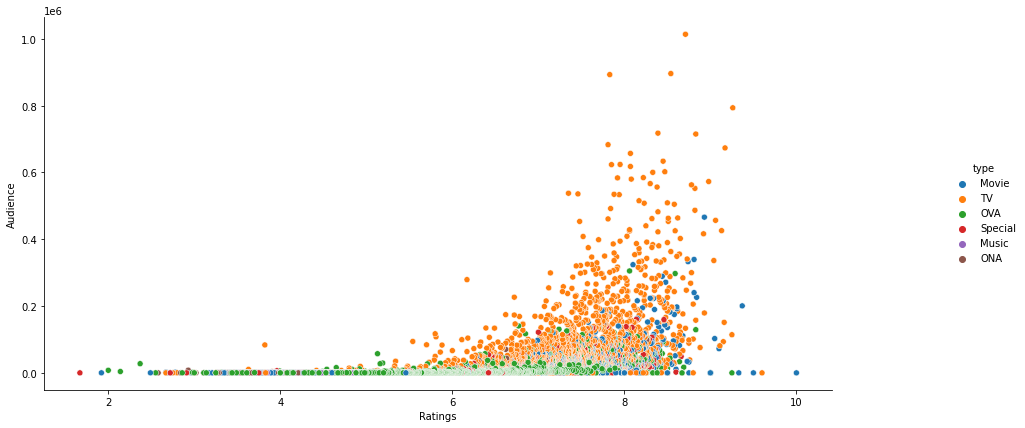

In [ ]:
def scatter(df):    
    g = sns.relplot(data=df,x='rating',y='members',hue='type') #,hue='type',size='episodes',scatter_kws= {"s":100})
    g.fig.set_size_inches(15,6)
    plt.xlabel('Ratings')
    plt.ylabel('Audience')

scatter(anime_df)

    

Let's focus on items that have a rating above average and amount of members above average in the dataset

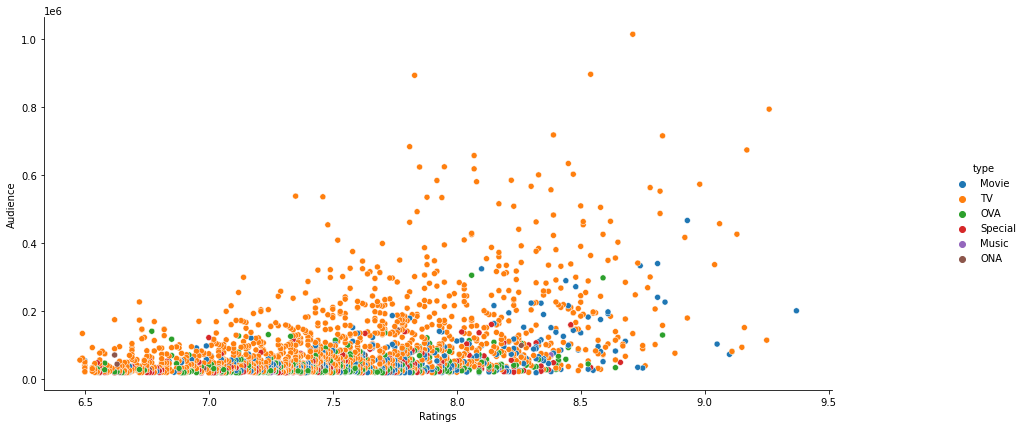

In [ ]:
scatter(anime_df[(anime_df['members']>anime_df['members'].mean()) & (anime_df['rating']>anime_df['rating'].mean())])

Let's see the distribution plots of ratings and members.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


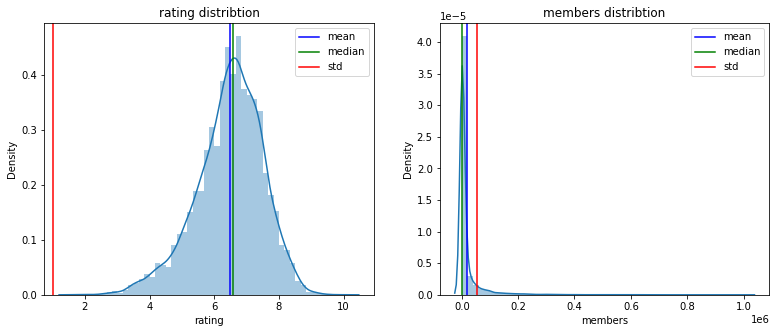

In [ ]:
fig=plt.figure(figsize=(13,5))
for i,j in zip(anime_df[['rating','members']].columns,range(3)):
    ax=fig.add_subplot(1,2,j+1)
    sns.distplot(anime_df[i],ax=ax)
    plt.axvline(anime_df[i].mean(),label='mean',color='blue')
    plt.axvline(anime_df[i].median(),label='median',color='green')
    plt.axvline(anime_df[i].std(),label='std',color='red')
    plt.title('{} distribtion'.format(i))
    plt.legend()
plt.show()

### 3.1.2 Prepare the data
The purpose of this component is to prepare the data for training models.

For example: treat missing values, clean the data, craft new features, normalize the data, etc.'.

In [ ]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


We can notice that some values within the rating column contain -1 values. These values indicated missing values.

However, we need to check if there are invalid values within the anime df as well.

#### Missing Values

##### Rating
We decide to drop the missing records.

In [ ]:
rating_df = rating_df[rating_df['rating']>-1]
rating_df.reset_index(inplace=True,drop=True)
rating_df.head()

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10


In [ ]:
print('there are {} nan values within the rating column'.format(anime_df['rating'].isnull().sum()))
anime_df[anime_df['rating']< 0]

there are 230 nan values within the rating column


,anime_id,name,genre,type,episodes,rating,members


The anime df has a few null values, but dropping these rows might affect the performance as we should take into considerations that we will need the combinations between animes and users

In [ ]:
"""
we will replace null values from categorical columns with "NULL"(like it's a new category) 
and for the rating column we will use the mean
"""
anime_df.rating.fillna(anime_df.rating.mean(),inplace=True)

##### Categorical Features

In [ ]:
anime_df.isnull().sum()

anime_id     0
name         0
genre       62
type        25
episodes     0
rating       0
members      0
dtype: int64

We can observe that some categorical features contain null values.

We will replace null values from categorical columns with "NULL" (like it's a new category)

In [ ]:

anime_df.genre.fillna("NULL",inplace=True)
anime_df.type.fillna("NULL",inplace=True)

#### Check and Remove Duplicates

In [ ]:
rating_df[rating_df.duplicated()]

,user_id,anime_id,rating
3637198,42653,16498,8


In [ ]:
rating_df[(rating_df['user_id']==42653) & (rating_df['anime_id'] == 16498)]

,user_id,anime_id,rating
3637140,42653,16498,8
3637198,42653,16498,8


In [ ]:
rating_df.drop_duplicates(inplace=True,keep='last')

#### Data filtering/ cleaning

It is possible that some anime appeared at the rating dataframe but are not appearing in the anime dataframe

Let's check it

In [ ]:
invalid_animes = [x  for x in rating_df.anime_id.unique() if x not in anime_df.anime_id.unique() ] 
invalid_animes

[30913]

In [ ]:
rating_df[rating_df['anime_id']==30913]

,user_id,anime_id,rating
2965245,34240,30913,9
3208806,37442,30913,9


In [ ]:
rating_df = rating_df[rating_df['anime_id'] != 30913]

##### Dummies

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_df['genre'] = anime_df['genre'].apply(lambda x: x.strip().replace(" ",""))

In [ ]:
genre_df = anime_df['genre'].str.get_dummies(sep=',')
genre_df


,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,MartialArts,Mecha,Military,Music,Mystery,NULL,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,ShoujoAi,Shounen,ShounenAi,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12290,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12291,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12292,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
anime_df.drop(['genre'],axis=1,inplace=True)
anime_df = anime_df.join(genre_df)
anime_df.head()

,anime_id,name,type,episodes,rating,members,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,MartialArts,Mecha,Military,Music,Mystery,NULL,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,ShoujoAi,Shounen,ShounenAi,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
anime_df = pd.get_dummies(anime_df,prefix=['type'],columns=['type'])
anime_df.head()

,anime_id,name,episodes,rating,members,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,MartialArts,Mecha,Military,Music,Mystery,NULL,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,ShoujoAi,Shounen,ShounenAi,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri,type_Movie,type_Music,type_NULL,type_ONA,type_OVA,type_Special,type_TV
0,32281,Kimi no Na wa.,1,9.37,200630,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,28977,Gintama°,51,9.25,114262,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9253,Steins;Gate,24,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,9969,Gintama&#039;,51,9.16,151266,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


##### Rename columns

In [ ]:
rating_df.rename(columns={'rating':'user_rating'},inplace=True)
anime_df.rename(columns={'rating':'anime_average_rating'},inplace=True)


#### Merge dataframes

In [ ]:
merge_df =pd.merge(rating_df,anime_df,on='anime_id')
merge_df.head()

,user_id,anime_id,user_rating,name,episodes,anime_average_rating,members,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,MartialArts,Mecha,Military,Music,Mystery,NULL,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,ShoujoAi,Shounen,ShounenAi,SliceofLife,Space,Sports,SuperPower,Supernatural,Thriller,Vampire,Yaoi,Yuri,type_Movie,type_Music,type_NULL,type_ONA,type_OVA,type_Special,type_TV
0,1,8074,10,Highschool of the Dead,12,7.46,535892,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,3,8074,6,Highschool of the Dead,12,7.46,535892,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,5,8074,2,Highschool of the Dead,12,7.46,535892,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,12,8074,6,Highschool of the Dead,12,7.46,535892,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,14,8074,6,Highschool of the Dead,12,7.46,535892,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
del anime_df, rating_df, genre_df

In [ ]:
from collections import Counter
minimum_ratings = 150
user_counter = Counter(merge_df['user_id'])
users_to_keep = [u[0] for u in user_counter.items() if u[1] >= minimum_ratings]

merge_df = merge_df[merge_df['user_id'].isin(users_to_keep)]


In [ ]:
print('the shape of the data after filtering users with less than {} interactions: {}'
.format(minimum_ratings,merge_df.shape))

the shape of the data after filtering users with less than 150 interactions: (3902206, 58)


In [ ]:
merge_df.to_pickle("merge_df.pkl")

In [ ]:
import pandas as pd
merge_df = pd.read_pickle("/content/anime/merge_df.pkl")


#### Encoding spliting and normlizing

There are several common strategies for splitting data:
[Exploring Data Splitting Strategies for the Evaluation of Recommendation Models - A paper from RecSys 2020 conference](https://dl.acm.org/doi/pdf/10.1145/3383313.3418479?casa_token=Rtj4uVMsBocAAAAA:T546JbGB4JI1E9EueDazTbMWm0xBGYovQQqD-hSmTqOM50WNkEUcuBFCTvPFUOE_SQSNWpZFeCreVg).





In [ ]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

animeEncoder = LabelEncoder()
userEncoder = LabelEncoder()

# anime ids are not consecutive numbers, we will have to label encode them for the embedding layer 
merge_df["anime_id"] = animeEncoder.fit_transform(merge_df["anime_id"])
merge_df["user_id"] = animeEncoder.fit_transform(merge_df["user_id"])


## 3.2 Spliting Data
In this section, we will split the available data into train, validation, and test sets.


###### Random - User Split
Make sure that each user appears in train and test sets.
Keep the class distribution equally for training and testing.

In [ ]:
def get_class_counts(df):
    grp = df.groupby(['user_rating'])['user_id'].nunique()
    return {key: grp[key] for key in list(grp.keys())}

def get_class_proportions(df):
    class_counts = get_class_counts(df)
    total_count = sum(class_counts.values())
    return {val[0]: round(val[1]/total_count,4) for val in class_counts.items()}

In [ ]:
print('Dataset class proportions',get_class_proportions(merge_df))

Dataset class proportions {1: 0.031, 2: 0.0429, 3: 0.0588, 4: 0.0919, 5: 0.1173, 6: 0.1298, 7: 0.1326, 8: 0.1329, 9: 0.1329, 10: 0.13}


In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
train_lst,validation_lst,test_lst = [],[],[]
users_to_keep = list(set(merge_df['user_id']))
for user in tqdm(users_to_keep):
    user_df = merge_df[merge_df['user_id']== user]        
    train, test = train_test_split(merge_df[merge_df['user_id']== user] , test_size = 0.2,random_state=42)
    train, validation = train_test_split(train, test_size = 0.1,random_state=42)
    train_lst.append(train)
    validation_lst.append(validation)
    test_lst.append(test)   

# print('Train class proportions',get_class_proportions(train))
# print('Validation class proportions',get_class_proportions(validation))
# print('Test class proportions',get_class_proportions(test))


100%|██████████| 12906/12906 [03:42<00:00, 57.91it/s]


In [ ]:
train = pd.concat(train_lst)
validation = pd.concat(validation_lst)
test = pd.concat(test_lst)

##### Normalize data
**We do not want to normalize the data before the split to avoid some leakage and additional information regarding the test set while training using the training set.**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

members_scaler = MinMaxScaler()
avg_rating_scaler = MinMaxScaler()

train["scaled_members"] = members_scaler.fit_transform(train["members"].to_numpy().reshape(-1,1))[:,0]
validation["scaled_members"] = members_scaler.transform(validation["members"].to_numpy().reshape(-1,1))[:,0]
test["scaled_members"] = members_scaler.transform(test["members"].to_numpy().reshape(-1,1))[:,0]


train["scaled_anime_average_rating"] = avg_rating_scaler.fit_transform(train["anime_average_rating"].to_numpy().reshape(-1,1))[:,0]
validation["scaled_anime_average_rating"] = avg_rating_scaler.transform(validation["anime_average_rating"].to_numpy().reshape(-1,1))[:,0]
test["scaled_anime_average_rating"] = avg_rating_scaler.transform(test["anime_average_rating"].to_numpy().reshape(-1,1))[:,0]

train.drop(['members','anime_average_rating'],inplace=True,axis=1)
validation.drop(['members','anime_average_rating'],inplace=True,axis=1)
test.drop(['members','anime_average_rating'],inplace=True,axis=1)

In [ ]:
train_y = train['user_rating']*1.0
train_x = train.drop(['user_rating','name'],axis=1)

validation_y = validation['user_rating']*1.0
validation_x = validation.drop(['user_rating','name'],axis=1)

test_y = test['user_rating']*1.0
test_x = test.drop(['user_rating','name'],axis=1)

In [ ]:
del train,validation,test

## 3.3 Modeling and training
The purpose of this component is to create a model for the recommendations. 
For example, use the Matrix Factorization model.
Then, we train the model build upon our training set.

This section is divided into two:
1. Building and Training models.
2. Optimization on the validation set

### 3.3.1 Building Models

We need to define our algorithms:

Baseline:




* Neural Matrix Factorization without biases
* Neural Matrix Factorization including user and item biases

Suggested:

- (a) Neural Matrix Factorization including a user, item, and members

- (b) Neural Matrix Factorization with a user, item, and members biases and additional layers

In [ ]:
from keras import backend as K
from keras import Model
from keras.layers import Input,Dense,Embedding,Flatten,Dot,Add,Lambda,Concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [ ]:
#Custom loss in keras
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true*1.0))) 

#### Neural Matrix Factorization without biases - baseline

In [ ]:
def create_dnn_mf_model_without_biases(num_users,num_items,emb_size):
    #define inputs        
    user_input = Input(shape=[1], name = 'user_input')
    item_input = Input(shape=[1], name = 'item_input')
        
    #define embeddings
    user_emb = Embedding(input_dim = num_users, output_dim = emb_size, name = 'mf_embedding_user')
    item_emb = Embedding(input_dim = num_items, output_dim = emb_size, name = 'mf_embedding_item')       

    # MF part
    mf_user_latent = Flatten()(user_emb(user_input))
    mf_item_latent = Flatten()(item_emb(item_input))
    mf_vector = Dot(axes=1)([mf_user_latent, mf_item_latent]) # element-wise multiply    

    sigmoid_prediction = Dense(1, activation='sigmoid', name = "prediction")(mf_vector)
    rating_prediction = Lambda(lambda x: x * 10.0)(sigmoid_prediction)

    model = Model(inputs=[user_input, item_input], 
                  outputs=rating_prediction)
    
    model.compile(optimizer='adam',loss=root_mean_squared_error)
    return model


In [ ]:
num_users = merge_df['user_id'].nunique()+1
num_items = merge_df['anime_id'].nunique()+1
model_without_bias = create_dnn_mf_model_without_biases(num_users,num_items,64)



In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(min_delta=0.01, patience=3)
mc = ModelCheckpoint(filepath='./model_without_bias.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model_without_bias.fit(x=[train_x['user_id'],train_x['anime_id']], y=train_y ,epochs=20, batch_size= 1024, validation_data=([validation_x['user_id'],validation_x['anime_id']],validation_y),callbacks=[es,mc])

Epoch 1/20
2734/2734 [==============================] - 36s 13ms/step - loss: 1.4382 - val_loss: 1.1433
Epoch 2/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.0766 - val_loss: 1.1130
Epoch 3/20
2734/2734 [==============================] - 35s 13ms/step - loss: 0.9809 - val_loss: 1.1246
Epoch 4/20
2734/2734 [==============================] - 36s 13ms/step - loss: 0.9139 - val_loss: 1.1424
Epoch 5/20
2734/2734 [==============================] - 37s 13ms/step - loss: 0.8725 - val_loss: 1.1586


#### Neural Matrix Factorization **with user and item biases** - baseline


In [ ]:
def create_dnn_mf_model_with_biases(num_users,num_items,emb_size):
    #define inputs        
    user_input = Input(shape=[1], name = 'user_input')
    item_input = Input(shape=[1], name = 'item_input')
        
    #define embeddings
    user_emb = Embedding(input_dim = num_users, output_dim = emb_size, name = 'mf_embedding_user')
    item_emb = Embedding(input_dim = num_items, output_dim = emb_size, name = 'mf_embedding_item')       

    # MF part
    mf_user_latent = Flatten()(user_emb(user_input))
    mf_item_latent = Flatten()(item_emb(item_input))
    mf_vector = Dot(axes=1)([mf_user_latent, mf_item_latent]) # element-wise multiply

    # Bias
    user_bias = Dense(1)(user_input)
    item_bias = Dense(1)(item_input)

    mf_score = Add()([mf_vector,user_bias,item_bias])
    sigmoid_prediction = Dense(1, activation='sigmoid', name = "prediction")(mf_score)
    rating_prediction = Lambda(lambda x: x * 10.0)(sigmoid_prediction)

    model = Model(inputs=[user_input, item_input], 
                  outputs=rating_prediction)
    model.compile(optimizer='adam',loss=root_mean_squared_error)
    return model

In [ ]:
model_with_bias = create_dnn_mf_model_with_biases(num_users,num_items,64)

In [ ]:
model_with_bias.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_embedding_user (Embedding)   (None, 1, 64)        826048      user_input[0][0]                 
__________________________________________________________________________________________________
mf_embedding_item (Embedding)   (None, 1, 64)        631296      item_input[0][0]                 
_______________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(min_delta=0.01, patience=3)
mc = ModelCheckpoint(filepath='./model_with_bias.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model_with_bias.fit(x=[train_x['user_id'],train_x['anime_id']], y=train_y ,epochs=20, batch_size= 1024, validation_data=([validation_x['user_id'],validation_x['anime_id']],validation_y),callbacks=[es,mc])

Epoch 1/20
2734/2734 [==============================] - 35s 13ms/step - loss: 6.5691 - val_loss: 2.8271
Epoch 2/20
2734/2734 [==============================] - 35s 13ms/step - loss: 5.1680 - val_loss: 2.7620
Epoch 3/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.8930 - val_loss: 1.2595
Epoch 4/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.1991 - val_loss: 1.1757
Epoch 5/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.1615 - val_loss: 1.1552
Epoch 6/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.1478 - val_loss: 1.1527
Epoch 7/20
2734/2734 [==============================] - 36s 13ms/step - loss: 1.1364 - val_loss: 1.1383
Epoch 8/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.1248 - val_loss: 1.1462
Epoch 9/20
2734/2734 [==============================] - 35s 13ms/step - loss: 1.1108 - val_loss: 1.1302
Epoch 10/20
2734/2734 [==============================] - 36s 13m

#### Neural Matrix Factorization **with user,item and members biases** - suggested


In [ ]:
def create_dnn_mf_model_with_bias_and_members(num_users,num_items,emb_size):
    #define inputs        
    user_input = Input(shape=[1], name = 'user_input')
    item_input = Input(shape=[1], name = 'item_input')
    members_input = Input(shape=[1], name = 'members_input')    
        
    #define embeddings
    user_emb = Embedding(input_dim = num_users, output_dim = emb_size, name = 'mf_embedding_user')
    item_emb = Embedding(input_dim = num_items, output_dim = emb_size, name = 'mf_embedding_item')       

    # MF part
    mf_user_latent = Flatten()(user_emb(user_input))
    mf_item_latent = Flatten()(item_emb(item_input))
    mf_vector = Dot(axes=1)([mf_user_latent, mf_item_latent]) # element-wise multiply

    # Bias
    user_bias = Dense(1)(user_input)
    item_bias = Dense(1)(item_input)
    members_bias = Dense(1)(members_input)    

    mf_score = Add()([mf_vector,user_bias,item_bias,members_bias])
    # concat = Concatenate(name='concat')([mf_score, members_bias])
    sigmoid_prediction = Dense(1, activation='sigmoid', name = "prediction")(mf_score)
    rating_prediction = Lambda(lambda x: x * 10.0)(sigmoid_prediction)

    model = Model(inputs=[user_input, item_input,members_input], 
                  outputs=rating_prediction)
    model.compile(optimizer='adam',loss=root_mean_squared_error)
    return model

In [ ]:
model_with_bias_and_members = create_dnn_mf_model_with_bias_and_members(num_users,num_items,64)
model_with_bias_and_members.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_embedding_user (Embedding)   (None, 1, 64)        826048      user_input[0][0]                 
__________________________________________________________________________________________________
mf_embedding_item (Embedding)   (None, 1, 64)        631296      item_input[0][0]                 
_______________________________________________________________________________________

In [ ]:
es = EarlyStopping(min_delta=0.01, patience=3)
mc = ModelCheckpoint(filepath='./model_with_bias_and_members.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model_with_bias_and_members.fit(x=[train_x['user_id'],train_x['anime_id'],train_x['scaled_members']], y=train_y ,epochs=20, batch_size= 1024, validation_data=([validation_x['user_id'],validation_x['anime_id'],validation_x['scaled_members']],validation_y),callbacks=[es,mc])

Epoch 1/20
2734/2734 [==============================] - 36s 13ms/step - loss: 4.0029 - val_loss: 2.8275
Epoch 2/20
2734/2734 [==============================] - 37s 14ms/step - loss: 2.8335 - val_loss: 2.7958
Epoch 3/20
2734/2734 [==============================] - 37s 14ms/step - loss: 2.2906 - val_loss: 1.4438
Epoch 4/20
2734/2734 [==============================] - 38s 14ms/step - loss: 1.2579 - val_loss: 1.1843
Epoch 5/20
2734/2734 [==============================] - 37s 14ms/step - loss: 1.1708 - val_loss: 1.1600
Epoch 6/20
2734/2734 [==============================] - 37s 14ms/step - loss: 1.1536 - val_loss: 1.1562
Epoch 7/20
2734/2734 [==============================] - 37s 14ms/step - loss: 1.1449 - val_loss: 1.1483
Epoch 8/20
2734/2734 [==============================] - 37s 14ms/step - loss: 1.1327 - val_loss: 1.1426
Epoch 9/20
2734/2734 [==============================] - 37s 14ms/step - loss: 1.1195 - val_loss: 1.1277
Epoch 10/20
2734/2734 [==============================] - 37s 13m

#### Neural Matrix Factorization with user, item and members biases **and additional layers** - suggested
We extend our suggested approach and aim to investigate if adding additional layers will improve our model (e.g., lower RMSE on the test set).

In [ ]:
def create_dnn_mf_model_with_bias_and_members_and_additional_layers(num_users,num_items,emb_size):
    #define inputs        
    user_input = Input(shape=[1], name = 'user_input')
    item_input = Input(shape=[1], name = 'item_input')
    members_input = Input(shape=[1], name = 'members_input')    
        
    #define embeddings
    user_emb = Embedding(input_dim = num_users, output_dim = emb_size, name = 'mf_embedding_user')
    item_emb = Embedding(input_dim = num_items, output_dim = emb_size, name = 'mf_embedding_item')       

    # MF part
    mf_user_latent = Flatten()(user_emb(user_input))
    mf_item_latent = Flatten()(item_emb(item_input))
    mf_vector = Dot(axes=1)([mf_user_latent, mf_item_latent]) # element-wise multiply

    # Bias
    user_bias = Dense(1)(user_input)
    item_bias = Dense(1)(item_input)
    members_bias = Dense(1)(members_input)    

    mf_score = Add()([mf_vector,user_bias,item_bias])
    concat = Concatenate(name='concat')([mf_score, members_bias])
    fc1 = Dense(2,activation='relu')(concat)
    # fc2 = Dense(2,activation='relu')(fc1)
    sigmoid_prediction = Dense(1, activation='sigmoid', name = "prediction")(fc1)
    rating_prediction = Lambda(lambda x: x * 10.0)(sigmoid_prediction)

    model = Model(inputs=[user_input, item_input,members_input], 
                  outputs=rating_prediction)
    model.compile(optimizer='adam',loss=root_mean_squared_error)
    return model

In [ ]:
model_with_bias_and_members_and_additional_layers = create_dnn_mf_model_with_bias_and_members_and_additional_layers(num_users,num_items,64)
model_with_bias_and_members_and_additional_layers.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mf_embedding_user (Embedding)   (None, 1, 64)        826048      user_input[0][0]                 
__________________________________________________________________________________________________
mf_embedding_item (Embedding)   (None, 1, 64)        631296      item_input[0][0]                 
_______________________________________________________________________________________

In [ ]:
es = EarlyStopping(min_delta=0.01, patience=3)
mc = ModelCheckpoint(filepath='./model_with_bias_and_members_and_layers.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model_with_bias_and_members_and_additional_layers.fit(x=[train_x['user_id'],train_x['anime_id'],train_x['scaled_members']], y=train_y ,epochs=20, batch_size= 1024, validation_data=([validation_x['user_id'],validation_x['anime_id'],validation_x['scaled_members']],validation_y),callbacks=[es,mc])

Epoch 1/20
2734/2734 [==============================] - 39s 14ms/step - loss: 1.8421 - val_loss: 1.5660
Epoch 2/20
2734/2734 [==============================] - 38s 14ms/step - loss: 1.5705 - val_loss: 1.5665
Epoch 3/20
2734/2734 [==============================] - 38s 14ms/step - loss: 1.5705 - val_loss: 1.5668
Epoch 4/20
2734/2734 [==============================] - 38s 14ms/step - loss: 1.5705 - val_loss: 1.5667


In [ ]:
model_with_bias_and_members_and_additional_layers = load_model('./model_with_bias_and_members_and_layers.h5',compile=False)
model_with_bias_and_members_and_additional_layers.compile(optimizer='adam',loss=root_mean_squared_error)
model_with_bias_and_members_and_additional_layers.evaluate(x=[test_x['user_id'],test_x['anime_id'],test_x['scaled_members']],y=test_y,batch_size=4096)

192/192 [==============================] - 0s 2ms/step - loss: 1.5693


1.5693069696426392

### 3.3.2 Hyper parameters optimization and tuning
The purpose of this component is to optimize the parameters for our problem. For example, embedding size, number of epochs, batch size, regularization factors, etc.'.

For example, if we will decrease embedding size and create a new model. We will have fewer parameters. Additionally, the results may be different.
There are several ways to optimize the hyper-parameters. 

For example:
* Manual Grid Search
* Hyperopt
* Genetic Algorithms 
* etc.'

#### Manual Grid Search
We will create a grid search and save all the results in a dictionary.

In [ ]:
def create_dnn_model_with_param(num_users,num_items,emb_size,batch,lr,name):
    #define inputs        
    user_input = Input(shape=[1], name = 'user_input')
    item_input = Input(shape=[1], name = 'item_input')
    members_input = Input(shape=[1], name = 'members_input')    
        
    #define embeddings
    user_emb = Embedding(input_dim = num_users, output_dim = emb_size, name = 'mf_embedding_user')
    item_emb = Embedding(input_dim = num_items, output_dim = emb_size, name = 'mf_embedding_item')       

    # MF part
    mf_user_latent = Flatten()(user_emb(user_input))
    mf_item_latent = Flatten()(item_emb(item_input))
    mf_vector = Dot(axes=1)([mf_user_latent, mf_item_latent]) # element-wise multiply

    # Bias
    user_bias = Dense(1)(user_input)
    item_bias = Dense(1)(item_input)
    members_bias = Dense(1)(members_input)    

    mf_score = Add()([mf_vector,user_bias,item_bias,members_bias])
    # concat = Concatenate(name='concat')([mf_score, members_bias])
    sigmoid_prediction = Dense(1, activation='sigmoid', name = "prediction")(mf_score)
    rating_prediction = Lambda(lambda x: x * 10.0)(sigmoid_prediction)

    model = Model(inputs=[user_input, item_input,members_input], 
                  outputs=rating_prediction)
    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam,loss=root_mean_squared_error)
    es = EarlyStopping(min_delta=0.01, patience=3)
    mc = ModelCheckpoint(filepath=f'./{name}.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    model.fit(x=[train_x['user_id'],train_x['anime_id'],train_x['scaled_members']], y=train_y ,epochs=20, batch_size= batch, validation_data=([validation_x['user_id'],validation_x['anime_id'],validation_x['scaled_members']],validation_y),callbacks=[es,mc])
    return model

In [ ]:
# grid definition
embedding_sizes = [64,256,512]
learning_rates = [0.005,0.001]
batch_sizes = [1024,4096]

# variable creation to store the values
log_models = {}


# counter
i = 0
# grid search
for emb in embedding_sizes:
    for lr in learning_rates:
        for batch in batch_sizes:            
            model = create_dnn_model_with_param(num_users,num_items,emb,batch,lr,i)
            print('[{}] Result: {}'.format(i, model))
            model = load_model(f'./{i}.h5',compile=False)
            adam = Adam(lr)
            model.compile(optimizer=adam,loss=root_mean_squared_error)                
            model_scores = model.evaluate(x=[validation_x['user_id'],validation_x['anime_id'],validation_x['scaled_members']],y=validation_y,batch_size=4096)
            current_param = (i,emb,lr,batch)
            log_models[current_param] = model_scores
            i += 1
            del model 
            print('model {} has been evaluated'.format(i))
                

Epoch 1/20
2734/2734 [==============================] - 37s 14ms/step - loss: 5.4016 - val_loss: 2.8275
Epoch 2/20
2734/2734 [==============================] - 36s 13ms/step - loss: 2.8359 - val_loss: 2.8275
Epoch 3/20
2734/2734 [==============================] - 37s 14ms/step - loss: 2.8359 - val_loss: 2.8274
Epoch 4/20
2734/2734 [==============================] - 36s 13ms/step - loss: 2.8358 - val_loss: 2.8274
[0] Result: <tensorflow.python.keras.engine.functional.Functional object at 0x7fc8a85422e8>
78/78 [==============================] - 0s 2ms/step - loss: 2.8312
model 1 has been evaluated
Epoch 1/20
684/684 [==============================] - 11s 16ms/step - loss: 7.7983 - val_loss: 7.8013
Epoch 2/20
684/684 [==============================] - 11s 16ms/step - loss: 7.7982 - val_loss: 7.8013
Epoch 3/20
684/684 [==============================] - 11s 16ms/step - loss: 7.7982 - val_loss: 7.8013
Epoch 4/20
684/684 [==============================] - 11s 16ms/step - loss: 3.4315 - val_lo

Presenting all results obtained by the hyperparameter tuning process


In [ ]:
log_models

{(0, 64, 0.005, 1024): 2.8311710357666016,
 (1, 64, 0.001, 4096): 2.8310863971710205,
 (2, 64, 0.005, 1024): 1.0935245752334595,
 (3, 64, 0.001, 4096): 2.8254315853118896,
 (4, 256, 0.005, 1024): 2.8309969902038574,
 (5, 256, 0.001, 4096): 2.8291175365448,
 (6, 256, 0.005, 1024): 1.0885319709777832,
 (7, 256, 0.001, 4096): 2.8311755657196045,
 (8, 512, 0.005, 1024): 2.831174612045288,
 (9, 512, 0.001, 4096): 2.83126163482666,
 (10, 512, 0.005, 1024): 1.0932261943817139,
 (11, 512, 0.001, 4096): 3.044905662536621}

## 3.4 + 3.5 Applying the model and Compare predicted rating on the test set
Selecting the best model and apply it to the test set.



In [ ]:
key_min = min(log_models.keys(), key=(lambda k: log_models[k]))

key_min_index = key_min[0]
lr = key_min[2]
best_tune_model = load_model(f'./{key_min_index}.h5',compile=False)
adam = Adam(lr)
best_tune_model.compile(optimizer=adam,loss=root_mean_squared_error)                
model_scores = best_tune_model.evaluate(x=[test_x['user_id'],test_x['anime_id'],test_x['scaled_members']],y=test_y,batch_size=4096)
print(model_scores)

192/192 [==============================] - 1s 3ms/step - loss: 1.0879
1.0878732204437256


## 5. Analyze Results and Significance

In [ ]:
from scipy.stats import friedmanchisquare

We will compare the following models (for demonstrations):
1. model without bias
2. model with bias
3. best tuned model 

In [ ]:
basic_model = load_model('/content/anime/model_without_bias.h5',compile=False)
basic_model.compile(optimizer='adam',loss=root_mean_squared_error)
basic_predictions = basic_model.predict(x=[test_x['user_id'],test_x['anime_id']],batch_size=4096)

bias_model = load_model('/content/anime/model_with_bias.h5',compile=False)
bias_model.compile(optimizer='adam',loss=root_mean_squared_error)
bias_predictions = bias_model.predict(x=[test_x['user_id'],test_x['anime_id']],batch_size=4096)

best_tune_predictions = best_tune_model.predict(x= [test_x['user_id'],test_x['anime_id'],test_x['scaled_members']],batch_size=4096)


In [ ]:
alpha = 0.05
stats , pvalue = friedmanchisquare(basic_predictions,bias_predictions,best_tune_predictions)
if pvalue < alpha:
    print('passed the friedman test')

passed the friedman test


In [ ]:
from scipy.stats import ttest_ind

basic_stats , basic_pvalue = ttest_ind(basic_predictions,best_tune_predictions)
bias_stats , bias_pvalue = ttest_ind(bias_predictions,best_tune_predictions)
if basic_pvalue <= alpha and bias_pvalue <= alpha:
    print('passed the ttest')
else:
    print(f'basic pvalue: {basic_pvalue}')
    print(f'bias pvalue: {bias_pvalue}')




passed the ttest


In [ ]:
ttest_ind(bias_predictions,basic_predictions)


Ttest_indResult(statistic=array([4.91049565]), pvalue=array([9.08555644e-07]))

#Code Task:
At this notebook we did not perform cross-validation. 
Wrap the experiment in a way that a cross-validation is performed on the examined models.